![title](\dados\BBS-02_A-Crisis_Web-Banner.jpg)

# Projeto de análise de dados da COVID-19 no Brasil

## DIO - Digital Innovation One

### Ronaldo Nunes

Fazendo a improtação das bibliotecas necessárias para o projeto

In [260]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from fbprophet import Prophet

Importando os dados a serem analizados.

In [261]:
url = "https://raw.githubusercontent.com/Ronaldo-Nunes/Cursos/main/Geracao-Tech-Unimed-BH-Ciencia-Dados/predicao-dados-covid/dados/time-series-19-covid-combined.csv"
df = pd.read_csv(url, parse_dates=["Date"])
df

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0
...,...,...,...,...,...,...
231739,2022-04-12,Zimbabwe,NaN,247094,0.0,5460
231740,2022-04-13,Zimbabwe,NaN,247160,0.0,5460
231741,2022-04-14,Zimbabwe,NaN,247208,0.0,5462
231742,2022-04-15,Zimbabwe,NaN,247237,0.0,5462


Conferindo os tipos de dados das colunas.

In [262]:
df.dtypes

Date              datetime64[ns]
Country/Region            object
Province/State            object
Confirmed                  int64
Recovered                float64
Deaths                     int64
dtype: object

Criação de função para normalizar os nomes das colunas.

In [263]:
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "_", col_name).lower()

In [264]:
df.columns = [corrige_colunas(col) for col in df.columns]
df

,date,country_region,province_state,confirmed,recovered,deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0
...,...,...,...,...,...,...
231739,2022-04-12,Zimbabwe,NaN,247094,0.0,5460
231740,2022-04-13,Zimbabwe,NaN,247160,0.0,5460
231741,2022-04-14,Zimbabwe,NaN,247208,0.0,5462
231742,2022-04-15,Zimbabwe,NaN,247237,0.0,5462


## Análises

Primeiro, veremos quais os países constantes no dataset para, daí, extrairmos os dados relativos apenas ao Brasil.

In [265]:
df.country_region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [266]:
df.loc[df.country_region == "Brazil"]

,date,country_region,province_state,confirmed,recovered,deaths
25296,2020-01-22,Brazil,NaN,0,0.0,0
25297,2020-01-23,Brazil,NaN,0,0.0,0
25298,2020-01-24,Brazil,NaN,0,0.0,0
25299,2020-01-25,Brazil,NaN,0,0.0,0
25300,2020-01-26,Brazil,NaN,0,0.0,0
...,...,...,...,...,...,...
26107,2022-04-12,Brazil,NaN,30184286,0.0,661741
26108,2022-04-13,Brazil,NaN,30210934,0.0,661904
26109,2022-04-14,Brazil,NaN,30234024,0.0,662043
26110,2022-04-15,Brazil,NaN,30247302,0.0,662154


Como não há dados de províncias (Estados), removeremos a coluna com valores nulos.

In [267]:
df.drop(columns=["province_state"], inplace=True)
df

,date,country_region,confirmed,recovered,deaths
0,2020-01-22,Afghanistan,0,0.0,0
1,2020-01-23,Afghanistan,0,0.0,0
2,2020-01-24,Afghanistan,0,0.0,0
3,2020-01-25,Afghanistan,0,0.0,0
4,2020-01-26,Afghanistan,0,0.0,0
...,...,...,...,...,...
231739,2022-04-12,Zimbabwe,247094,0.0,5460
231740,2022-04-13,Zimbabwe,247160,0.0,5460
231741,2022-04-14,Zimbabwe,247208,0.0,5462
231742,2022-04-15,Zimbabwe,247237,0.0,5462


## Casos confirmados no Brasil

In [268]:
brasil = df.loc[(df.country_region == "Brazil") & (df.confirmed > 0)]
brasil

,date,country_region,confirmed,recovered,deaths
25331,2020-02-26,Brazil,1,0.0,0
25332,2020-02-27,Brazil,1,0.0,0
25333,2020-02-28,Brazil,1,0.0,0
25334,2020-02-29,Brazil,2,0.0,0
25335,2020-03-01,Brazil,2,0.0,0
...,...,...,...,...,...
26107,2022-04-12,Brazil,30184286,0.0,661741
26108,2022-04-13,Brazil,30210934,0.0,661904
26109,2022-04-14,Brazil,30234024,0.0,662043
26110,2022-04-15,Brazil,30247302,0.0,662154


In [269]:
px.line(brasil, "date", "confirmed",
        labels={"date": "Período", "confirmed": "Número de casos confirmados"},
        title="Casos confirmados no Brasil")

## Número de novos casos por dia

In [270]:
# Implementação de função para realizar a contagem de novos casos por dia
brasil["novos_casos_dia"] = list(map(
        lambda x: 0 if x == 0 else brasil["confirmed"].iloc[x] - brasil["confirmed"].iloc[x-1],
        np.arange(brasil.shape[0])
    )
)

brasil["novas_mortes_dia"] = list(map(
        lambda x: 0 if x == 0 else brasil["deaths"].iloc[x] - brasil["deaths"].iloc[x-1],
        np.arange(brasil.shape[0])
    )
)

C:\Users\reneh\AppData\Local\Temp\ipykernel_23404\3738134368.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\reneh\AppData\Local\Temp\ipykernel_23404\3738134368.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [271]:
# Visualizando os dados no gráfico
px.line(brasil, "date", "novos_casos_dia",
        labels={"date": "Período", "novos_casos_dia": "Novos casos"},
        title="Novos casos registrados por dia")

## Mortes

In [272]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil.date, y=brasil.deaths, name="Mortes", line=dict(color="red"))
)

fig.update_layout(title="Mortes por COVID-19 no Brasil", xaxis_title="Período", yaxis_title="Número de mortes")
fig.show()

In [273]:
px.line(brasil, "date", "novas_mortes_dia",
        labels={"date": "Período", "novas_mortes_dia": "Novas mortes"},
        title="Novos óbitos registrados por dia")

## Comparação dos casos confirmados e pessoas recuperadas

In [274]:
fig = go.Figure()

# Casos confirmados
fig.add_trace(go.Scatter(x=brasil.date, y=brasil.confirmed, name="Confirmados", line=dict(color="orange")))

# Recuperados
fig.add_trace(go.Scatter(x=brasil.date, y=brasil.recovered, name="Curados", line=dict(color="green")))

fig.update_layout(title="Evolução da COVID-19 no Brasil", xaxis_title="Período", yaxis_title="Número de registros")
fig.show()

É possível vislumbrar a proximidade das curvas de infectados e pessoas recuperadas, ao menos até 04 de agosto de 2021, data do último registro para essa medida.

## Taxa de crescimento

Calculando a taxa de crescimento do COVID desde o primeiro caso.

In [275]:
def taxa_crescimento(dados, variavel, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = dados.date.loc[dados[variavel] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)

    if data_fim == None:
        data_fim = dados.date.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)

    # Define os valores de presente e passado
    passado = dados.loc[dados.date == data_inicio, variavel].values[0]
    presente = dados.loc[dados.date == data_fim, variavel].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [276]:
cresc_medio = taxa_crescimento(brasil, 'confirmed')
print(f"O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID no Brasil no período avaliado foi de 2.23%.


Observaremos o comportamento da **taxa de crescimento no tempo**. Para isso, vamos definir uma função para calcular a taxa de crescimento diária.

In [277]:
def taxa_crescimento_diaria(dados, variavel, data_inicio=None):
    if data_inicio == None:
        data_inicio = dados.date.loc[dados[variavel] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = dados.date.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (dados[variavel].iloc[x] - dados[variavel].iloc[x-1]) / dados[variavel].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)*100

In [278]:
taxa_dia = taxa_crescimento_diaria(brasil, 'confirmed')

In [279]:
primeiro_dia = brasil.date.loc[brasil.confirmed > 0].min()
px.line(x=pd.date_range(primeiro_dia, brasil.date.max())[1:],
        y=taxa_dia, title='Taxa de crescimento de casos confirmados no Brasil',
        labels={'y':'Taxa de crescimento', 'x':'Período'}
)

In [280]:
taxa_mortes_dia = taxa_crescimento_diaria(brasil, 'deaths')

C:\Users\reneh\AppData\Local\Temp\ipykernel_23404\1845072759.py:10: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\reneh\AppData\Local\Temp\ipykernel_23404\1845072759.py:10: RuntimeWarning:

divide by zero encountered in longlong_scalars



In [281]:
primeira_morte = brasil.date.loc[brasil.deaths > 0].min()
px.line(x=pd.date_range(primeira_morte, brasil.date.max())[1:],
        y=taxa_mortes_dia, title='Taxa de crescimento de óbitos por COVID no Brasil',
        labels={'y':'Taxa de crescimento', 'x':'Período'}
)

# Predições

Constuindo um modelo de séries temporais para prever os novos casos. Mas antes analisemos a série temporal.

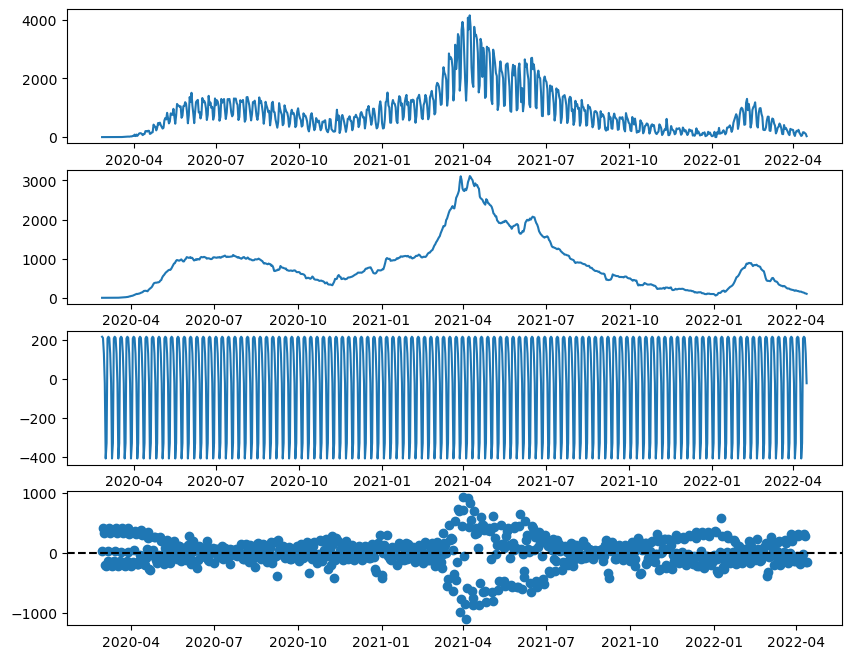

In [282]:
novas_mortes = brasil.novas_mortes_dia
novas_mortes.index = brasil.date

res = seasonal_decompose(novas_mortes)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novas_mortes.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

## Decompondo a série de confirmados

In [283]:
confirmados = brasil.confirmed
confirmados.index = brasil.date

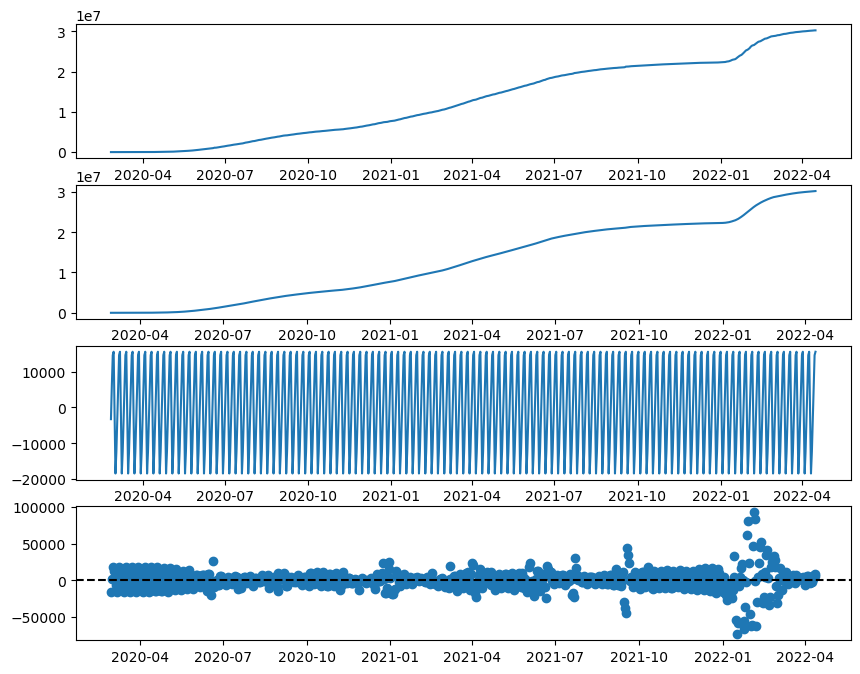

In [284]:
res2 = seasonal_decompose(confirmados)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res2.observed)
ax2.plot(res2.trend)
ax3.plot(res2.seasonal)
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

# Predizendo o número de mortes com um AUTO-ARIMA

In [285]:
!pip install pmdarima

In [286]:
from pmdarima.arima import auto_arima

In [287]:
df_mortes = brasil.loc[brasil.deaths > 0]
mortes = df_mortes.deaths
mortes.index = df_mortes.date
modelo = auto_arima(mortes)

In [288]:
mortes.index.max()

Timestamp('2022-04-16 00:00:00')

In [289]:
pd.date_range('2022-04-17', '2022-05-01')

DatetimeIndex(['2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20',
               '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24',
               '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28',
               '2022-04-29', '2022-04-30', '2022-05-01'],
              dtype='datetime64[ns]', freq='D')

In [290]:
fig = go.Figure(go.Scatter(
    x=mortes.index, y=mortes, name="Observados"
))

fig.add_trace(go.Scatter(x=mortes.index, y=modelo.predict_in_sample(), name="Previsão"))

fig.add_trace(go.Scatter(x=pd.date_range("2022-04-17", "2022-05-01"), y=modelo.predict(15), name="Forecast"))

fig.update_layout(title="Previsão de mortes para 15 dias após o último registro", 
                    yaxis_title="Mortes",
                    xaxis_title="Período")
fig.show()

# Forecasting com Facebook Prophet

In [291]:
limite = round(len(mortes) * -0.2)
mortes[:limite]

date
2020-03-17         1
2020-03-18         3
2020-03-19         6
2020-03-20        11
2020-03-21        15
               ...  
2021-11-11    610553
2021-11-12    611174
2021-11-13    611481
2021-11-14    611546
2021-11-15    611616
Name: deaths, Length: 609, dtype: int64

In [292]:
# preparando os dados
treino = mortes.reset_index()[:limite]
teste = mortes.reset_index()[limite:]

# renomeia colunas
treino.rename(columns={"date":"ds", "deaths":"y"}, inplace=True)
teste.rename(columns={"date":"ds", "deaths":"y"}, inplace=True)
teste = teste.set_index("ds")
teste = teste["y"]

profeta = Prophet()

populacao = 215316576

treino["cap"] = populacao

# Treinando o modelo
profeta.fit(treino)

# Construindo as previsões
future_dates = profeta.make_future_dataframe(periods=200)
future_dates["cap"] = populacao
forecast = profeta.predict(future_dates)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\reneh\anaconda3\envs\python_38\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\reneh\anaconda3\envs\python_38\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\reneh\anaconda3\envs\python_38\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [293]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=teste.index, y=teste, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=treino.ds, y=treino.y, name='Observados - Treino'))
fig.update_layout(title='Predições de mortes por COVID no Brasil')
fig.show()